<a href="https://colab.research.google.com/github/sefrancogo/Analitica-de-Datos/blob/master/Covid_Paises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wget 
import pandas as pd
import numpy as np #HOLA
import wget 
import matplotlib.pyplot as plt
%matplotlib inline

url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#path = 'data/Casos_positivos_de_COVID-19_en_Colombia04_15_2020.csv'

wget.download(url, 'datos_covid_paises.cvs')
data = pd.read_csv('datos_covid_paises.cvs')
data.head()

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=628e039ca0bbef8bd3432cd96c713315087bbe278574b7fae22b88f51a9b53bb
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25


In [0]:
#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:        
        X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
        y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
        pi += 1
        pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

In [0]:
#Ubicar Posicion de pais
ii = data[data.columns[1]] == 'Colombia'

#contagios  acumulados
serie = np.array(data.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))

X, y = covid_win(serie,w=5)
X_d, y_d = covid_win(serie_d,w=5)

### Analisis Exploratorio PCA

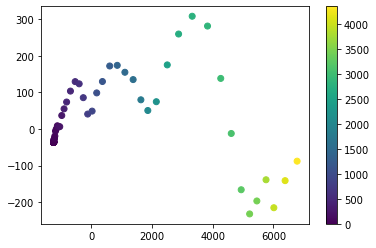

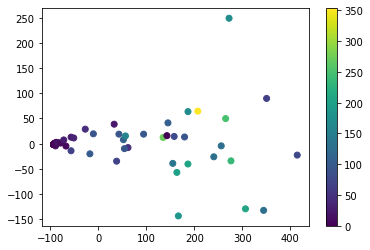

In [6]:
from sklearn.decomposition import PCA

red = PCA()
red_d = PCA()

z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Analisis Exploratorio TSNE

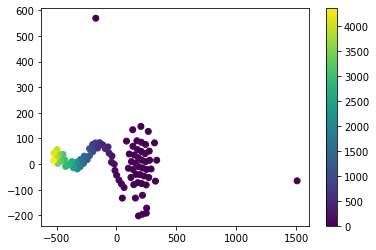

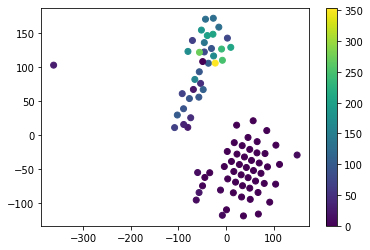

In [9]:
from sklearn.manifold import TSNE

red = TSNE(n_components = 2, perplexity=10)
red_d = TSNE(n_components = 2, perplexity=10)

z = red.fit_transform(X)
z_d = red.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Extrer conjunto de Entrenamiento y Prueba
Cuando se tienen pocos datos es necesario realizar una validaación cruzada anidada.

In [0]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from joblib import dump, load

steps = [
         [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),  #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))]
          ]

parameters = [
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
                 },
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]
               
label_model = ['NorSC-KRRBF','NorSC-PCA-KRRBF']

### Validación Cruzada Anidada

In [0]:
Niter = 10                           #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))   #arreglo para guardar acierto
best_estimators = []                 #mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = []                   #mejor metodo por iteracion 
          

for j in range(Niter): #outter loop
    print('it %d/%d'%(j+1,Niter))
    #particiono datos outter loop
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3) # xtrain 60, xtest 26
    for r in range(len(steps)): #recorro todos los posibles modelos a probar en iteracion j del outter loop
        grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_squared_error',n_jobs=5) #cv inner loop
        #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
        # cv = N -> leave one out N <30
        #generar mejor modelo
        grid_search.fit(X_train,y_train)
        #estimar salida conjunto de test
        y_pred = grid_search.best_estimator_.predict(X_test)
        #guardar mejor modelo
        best_estimators.append(grid_search.best_estimator_)
        best_hyperpar.append(grid_search.best_params_)

        #guardar acierto
        msev[j,r] = mse(y_test,y_pred)
        print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
        print(best_hyperpar)
        print('mse:',msev[j,r])

        savedata = {
          'acc':msev,
          'best_models':best_estimators,
          'best_parameters':best_hyperpar,
            } 
        #dump(savedata,'covid19_1.joblib')

it 1/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1790s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0722s.) Setting batch_size=10.
[Parallel(n_jobs=5)]: Done  57 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1657s.) Setting batch_size=24.
[Parallel(n_jobs=5)]: Done 133 out of 180 | elapsed:    5.9s remaining:    2.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    6.0s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: Deprecat

it 1/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 2815.210323050819
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1815s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0740s.) Setting batch_size=10.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1993s.) Setting batch_size=20.
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results

it 1/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 1624.8961711505467
it 2/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0360s.) Setting batch_size=10.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 2/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 2567.172654578734
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 220 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 310 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 420 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0240s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 2/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 1782.5742466442066
it 3/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.4s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=24.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 3/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}]
mse: 8965.718229796277
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 298 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.5s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=24.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 3/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}]
mse: 8089.36267907367
it 4/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.7s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0647s.) Setting batch_size=6.


it 4/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 1703.9653849899707
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 256 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 400 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 478 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    3.1s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel

it 4/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 1455.728823170804
it 5/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0200s.) Setting batch_size=18.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 5/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 2280.5460794018654
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 100 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 388 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0242s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 5/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 2324.0015135110507
it 6/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.4s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0360s.) Setting batch_size=10.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 6/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}]
mse: 8296.161013615678
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  60 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 220 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 310 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 420 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0400s.) Setting batch_size=10.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tas

it 6/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 3545.2659828190135
it 7/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1834s.) Setting batch_size=20.
[Parallel(n_jobs=5)]: Done  60 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.4s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0280s.) Setting batch_size=14.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 7/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}]
mse: 4450.617575584701
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 304 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0280s.) Setting batch_size=14.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 7/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}]
mse: 1174.520772703284
it 8/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 152 out of 180 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0280s.) Setting batch_size=14.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 8/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.001}]
mse: 4424.990576218058
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 304 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0560s.) Setting batch_size=6.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 8/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.001}, {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}]
mse: 5635.226640575404
it 9/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1565s.) Setting batch_size=14.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0440s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 9/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.001}, {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}]
mse: 1901.087347943801
Fitting 5 folds for each of

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 106 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 250 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 338 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0200s.) Setting batch_size=20.
[Parallel(n_jobs=5)]: Done   3 tas

it 9/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.001}, {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_c

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.4s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0320s.) Setting batch_size=12.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


it 10/10-Modelo 0/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.001}, {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 262 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 370 tasks      | elapsed:    1.3s


it 10/10-Modelo 1/2
[{'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.01, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.01}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.001}, {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}, {'reg__alpha': 0.001, 'reg__gamma': 0.1}, {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_

[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
C:\Users\Alba Cecilia G\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


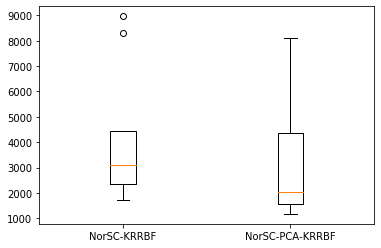

In [0]:
plt.boxplot(msev)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.show()